# Extract Shadow and Sun Masks from Near-IR

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrahnis/nb-vegetation/blob/main/Veggie-Forest.ipynb)

- Plot the Near-IR histogram
- Mask using a range condition
- Compare the shaded pixels vs the sun pixels
- Map the shade-adjacent sun pixels
    + Shift image?
    + Morphological opening?
    + Is L* of the added pixels greater? Yes then add to the sun sample set
- Should the Near-IR intensity be a weight somewhere?
- Saves the shade mask and sun mask

In [65]:
# if the notebook is running in colab we'll get the data from github
HOST_IS_COLAB = 'google.colab' in str(get_ipython())

if HOST_IS_COLAB:
    # if using the regular Colab runtime install rasterio and others packages
    !pip install rasterio --quiet --exists-action i
    !pip install fiona --quiet --exists-action i
    !pip install shapely --quiet --exists-action i
    path = 'https://github.com/mrahnis/nb-vegetation/blob/main'
    params = '?raw=true'
    !mkdir results
else:
    path = '.'
    params = ''

In [66]:
import timeit
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import colormaps
from matplotlib.patches import Patch, Rectangle
import fiona
import shapely
import rasterio
from rasterio.windows import from_bounds
from rasterio.features import shapes
from skimage import segmentation, feature, future, morphology
from skimage.exposure import histogram
from skimage.filters import rank, apply_hysteresis_threshold
from skimage.color import rgb2lab, lab2rgb, rgb2hsv
from sklearn.ensemble import RandomForestClassifier

In [67]:
"""Load RGB+NIR TIFF data"""
image_file = '{}/data/pa_greatmarsh_2022_naip.tif{}'.format(path, params)
src = rasterio.open(image_file)

# read band data
rgb = src.read()

# switch from band-first raster to band-last image to display later
img = np.moveaxis(src.read(), 0, 2)

In [68]:
"""Create a 3-band image in L*a*b* colorspace"""
lab = rgb2lab(rgb[:3,:,:], channel_axis=0)

# Make a mask

The shadows show up clearly in the Near-IR band. Let's try thresholding that to make a mask.

Text(0, 0.5, 'pixels')

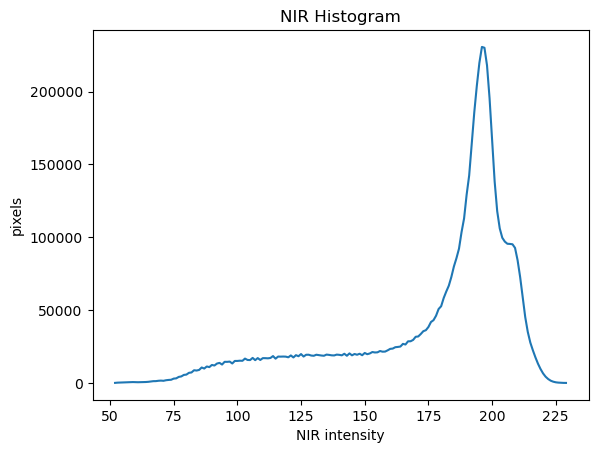

In [69]:
fig, ax = plt.subplots(1, 1)

V_hist, V_centers = histogram(rgb[3,:,:], nbins=256)
ax.plot(V_centers, V_hist)
ax.set_title("NIR Histogram")
ax.set_xlabel('NIR intensity')
ax.set_ylabel('pixels')

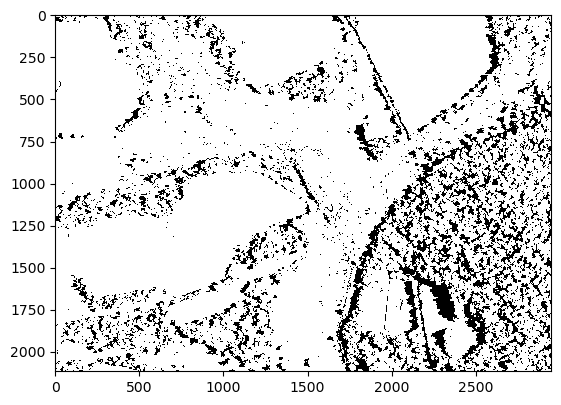

In [70]:

# this mask the shade pixels will be True and sunlight pixels will be False
#shade = (rgb[3,:,:] > 75) & (rgb[3,:,:] < 110)
_shade = ~apply_hysteresis_threshold(rgb[3,:,:], 130, 160)
water = apply_hysteresis_threshold(1./rgb[3,:,:], 1./80., 1./63.)
shade = morphology.binary_closing((_shade & ~water), morphology.disk(2, dtype=bool))

fig, ax = plt.subplots(1, 1)
ax.imshow(shade, cmap='gray_r', interpolation='none')

plt.show()

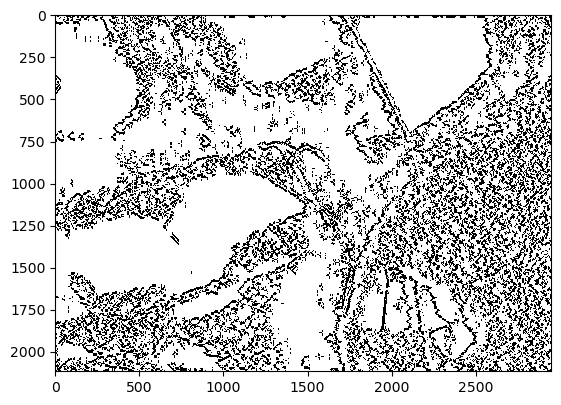

In [104]:
# Make a mask for the adjacent areas.
_sunlit = np.zeros_like(shade)

# produces same number pixels either way
for i in np.arange(3,18):
    #_sunlit = np.maximum(_sunlit, (np.roll(shade, -i, axis=1) ^ np.roll(shade, i, axis=0) ^ np.roll(shade, -i, axis=0)))
    _sunlit += (np.roll(shade, -i, axis=1) ^ np.roll(shade, i, axis=0) ^ np.roll(shade, -i, axis=0))
    
sunlit = (_sunlit & ~shade & ~(rgb[3,:,:] < 170))

fig, ax = plt.subplots(1, 1)
ax.imshow(sunlit, cmap='gray_r', interpolation='none')

plt.show()

In [105]:
print(f'shade pixels: {np.count_nonzero(shade)}')
print(f'sunlit pixels: {np.count_nonzero(sunlit)}')

shade pixels: 858818
sunlit pixels: 1372784


In [107]:
# Write out the shadow mask and sun mask
out_shade = './results/shadow_mask.tif'
out_sun = './results/sunlit_mask.tif'

with rasterio.open(
    out_shade,
    'w',
    driver='GTiff',
    height=shade.shape[0],
    width=shade.shape[1],
    count=1,
    dtype=np.uint8,
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(shade, 1)
    
with rasterio.open(
    out_sun,
    'w',
    driver='GTiff',
    height=sunlit.shape[0],
    width=sunlit.shape[1],
    count=1,
    dtype=np.uint8,
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(sunlit, 1)

src.close()